# Spurious-Free Dynamic Range (SFDR), Teil 1

Bei der digitalen Signalverarbeitung hat man es ja nicht nur mit diskreten **Abtastzeiten** zu tun, sondern auch mit diskreten **Amplitudenschritten**, und das führt zu spektralen Störungen. Diese spektralen Störungen ("**Spurs"**) sind immer da, auch wenn die Zeit- und Amplitudenschritte eines ADCs oder DACs alle perfekt sind.

Eine Analogspannung, die mit einem ADC diskreter Auflösung gemessen wird, sei er auch noch so perfekt, stimmt ja nur in einem unendlich kleinen Intervall mit dem ADC überein, nämlich nur dann, wenn exakt eine ADC-Stufe getroffen wird. Darüber und  darunter weicht die Analogspannung von dem Wert ab, den die ADC-Stufe repräsentiert, und alleine diese Abweichungen zwischen der kontinuierlichen Realität und dem ADC-Wert erzeugen schon spektrale Störungen. Darum geht es in dem Kapitel 2.5.2 des SDR-For-Engineers-Buchs: Störungen im Spektrum aufgrund einer endlichen Auflösung des Sampling- und Quantisierungsprozesses.

Im Buch *Software Defined Radio for Engineers*, das man [hier](https://www.analog.com/en/education/education-library/software-defined-radio-for-engineers.html) angucken kann, und im zugehörigen [Github-Repository](https://github.com/sdrforengineers) findet man zu Kapitel 2.5.5 die Skripts *sfdr_example.m* und *sfdr_test.m*.

Im Folgenden versuche ich, die MATLAB-Skripts in Python umzusetzen:

## SFDR in MATLAB vs. Python ##

MATLAB stellt zur Untersuchung und Darstellung der oben genannten Effekte die Funktion **sfdr(x, fs)** zu Verfügung, die im Buch ab Kapitel 2.5.2 auch ausführlich benutzt wird. Unter dem **Spurious-Free Dynamic Range** (SFDR) versteht man den Abstand der Leistung eines gewollten (Träger-)Signals zum höchsten Störsignal, das im Spektrum auftritt, gemessen in dB.

Trotz intensiver Suche habe ich leider keine Entsprechung für diese MATLAB-Funktion in **numpy**, **scipy**, **pandas** oder anderen Python-Bibliotheken gefunden. Deshalb hab ich versucht, eine möglichst ähnliche Funktion selber zu schreiben. Dabei habe ich wieder einiges gelernt:

### Erster Versuch ###
Mein erster Versuch sah so aus:

In [54]:
# First naive version of sfdr(x):
def sfdr(x,fs):
    Y = np.fft.rfft(x)
    freqs = np.fft.rfftfreq(len(x), d=1.0/fs)
    mag = np.abs(Y)
    YdB = 20 * np.log10(mag)
    fig, ax = plt.subplots()
    ax.plot(freqs, YdB)

Zum Testen rufen wir die Funktion auf dieselbe Weise auf wie in *sfdr_test.m*:

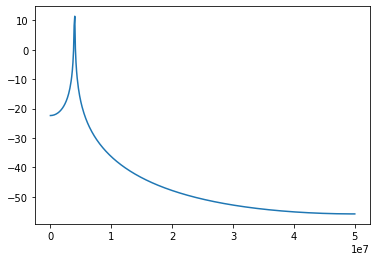

In [55]:
import matplotlib.pyplot as plt
import numpy as np
 
deltat = 1e-8
fs = 1/deltat
t = np.arange(0, 1e-5-deltat, deltat)
fundamental = 3959297 # Prime number
x = 10e-3*np.sin(2*np.pi*fundamental*t)
sfdr(x,fs)

Leider sieht das Ergebnis völlig anders aus als im SDR-Buch!
Man beachte zum Vergleich die Figure 2.28 b) auf Seite 53 in [dieser PDF-Datei des Buches!](https://www.analog.com/media/en/training-seminars/design-handbooks/Software-Defined-Radio-for-Engineers-2018/SDR4Engineers_CH02.pdf#page=14)
Der Dynamikbereich des Python-Plots oben umfasst mal gerade 70 dB oder so, während der Dynamikbereich des Plots mit MATLAB im Buch ungefähr 300 dB umfasst!
Woran liegt das?

#### Spectral Leakage ####
                                                                                         

Im obigen Python-Code wird eine Primzahl als Frequenz (3.959297 MHz) bei einer Abtastfrequenz von 100 MHz und 1000 Abtastwerten verwendet. Der Schwingungszug, der mit diesen Parametern erzeugt wird (siehe Codezeile 17), fängt zwar mit der Phase 0 an, hört aber wegen dieser Primzahl nicht so auf, dass der gedachte 1001. Abtastwert wieder mit der Phase 0 fortgesetzt werden kann.
Das schauen wir uns gleich mal mit ein paar Python-Kommandos an:

(9.7e-06, 1e-05)

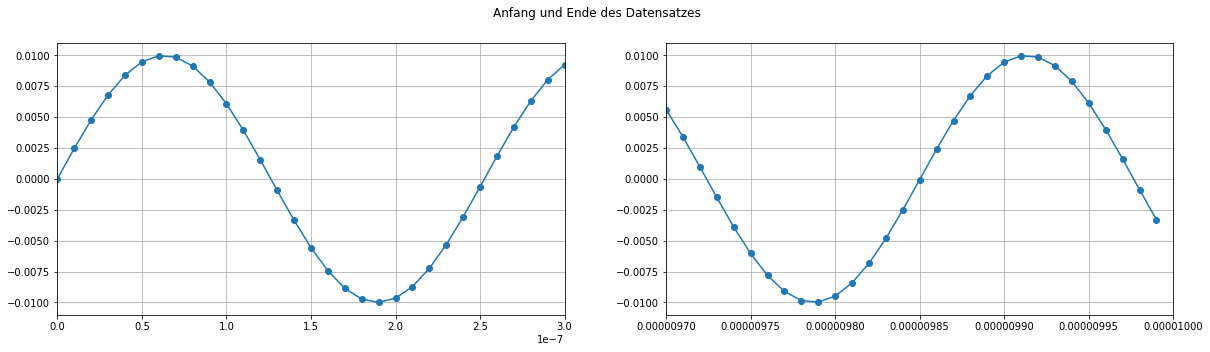

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Anfang und Ende des Datensatzes')
ax1.plot(t, x, "-o")
ax1.grid()
ax1.set_xlim(0,3e-7)
ax2.plot(t, x, "-o")
ax2.grid()
ax2.set_xlim(1000*1e-8 - 3e-7, 1000*1e-8)

Wie man sieht, hört der Schwingungszug mit einer deutlich negativen Amplitude auf. Der 1001. Abtastwert ist also ungleich 0, oder anders ausgedrückt, die Anzahl der Schwingungen, die in unseren Datensatz hineinpasst, ist keine ganze Zahl.
Wenn der Schwingungszug periodisch fortgesetzt wird, kommt es an den Stoßstellen zu Sprüngen der Amplitude.
Solch Amplitudensprünge erzeugen breitbandige Spektren, und genau das sieht man auch im FFT-Plot.
https://de.wikipedia.org/wiki/Leck-Effekt

Zum Ausprobieren erzeugen wir jetzt einen Schwingungszug, der passgenau periodisch fortgesetzt werden kann, und schauen uns gleich den Anfang und das Ende an:

(9.7e-06, 1e-05)

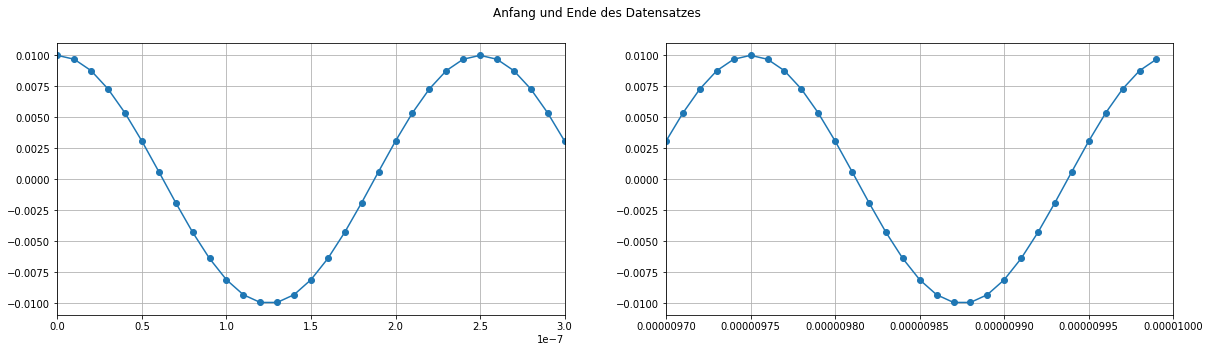

In [57]:
t = np.arange(0, 1e-5-deltat, deltat)
fundamental = 4000000 # Fits exactly
x = 10e-3*np.cos(2*np.pi*fundamental*t)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('Anfang und Ende des Datensatzes')
ax1.plot(t, x, "-o")
ax1.grid()
ax1.set_xlim(0,3e-7)
ax2.plot(t, x, "-o")
ax2.grid()
ax2.set_xlim(1000*1e-8 - 3e-7, 1000*1e-8)

Wie man erkennen kann, wäre die Fortsetzung des Datensatzes der gleiche Abtastwert wie am Anfang des Datensatzes.
Schauen wir uns den FFT-Plot an:

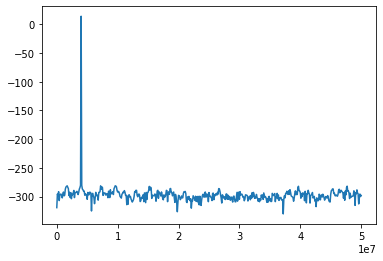

In [58]:
sfdr(x,fs)

Warum haben die Autoren dann eine Primzahl als Abtastfrequenz benutzt, wenn das zu diesem unschönen Leck-Effekt führt?

Die Antwort dazu ist:
Wenn man einen Schwingungszug mit einer ganzzahligen Anzahl von Perioden benutzt, das heißt wie im obigen Beispiel mit 2 MHz und 25 Perioden im Abtastblock, dann werden in jeder Periode immer die gleichen Abtaststufen benutzt.

Wenn ich im Extremfall 50 MHz verwenden würde, dann bestünde mein Schwingungszug nur aus einer Periode mit 2 Werten, nämlich der kleinsten und der größten Zahl, die ich abwechselnd ausgebe. Mit solchen Schwingungszügen kann ich den SFDR nicht sinnvoll angeben. Eine SFDR-Angabe hat nur Sinn, wenn möglichst alle möglichen Quantisierungsstufen dazu beitragen, denn ich will ja mit dem SFDR-Wert zum Beispiel einen ADC, DAC oder eine Signalverarbeitungsfunktion bezüglich ihrer Genauigkeit beurteilen.
Einen Beitrag aller möglichen Quantisierungsstufen bekomme ich aber nur dann, wenn sich die Abtastwerte nicht nach kurzer Zeit bzw. nach einigen Samples schon wiederholen. 

Irgendwie muss man dann aber dafür sorgen, dass die Leck-Effekte bzw. das *Spektral Leakage* geringere Störspektren verursachen als das SFDR.

Wie geht das?

#### FFT-Windowing ####

*Spectral Leakage* kann man durch *FFT-Windowing* verringern, das heißt, man sorgt dafür, dass der Anfang und das Ende des Abtastblocks sozusagen sanft auf 0 gedrückt wird. Man multipliziert dabei den zu transformierenden Datensatz mit einer geeigneten Fensterfunktion, bevor man die FFT aufruft.
Dabei wird zwar das *spectral leakage* verringert, aber es wird auch das Signal verändert, und man verliert dabei Frequenz- und/oder Amplitudenauflösung. Es gibt unzählige FFT-Fensterfunktionen die aber alle in der einen oder anderen Weise einen Kompromiss darstellen.

### Zweiter Versuch: Blackman-Harris-Fenster ###

Das Blackman-Harris-Fenster bietet eine sehr hohe Unterdrückung und sieht so aus:

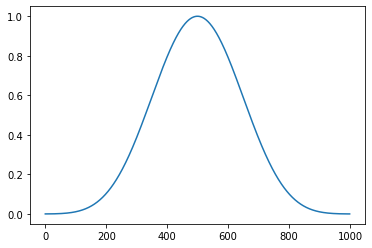

In [59]:
from scipy import signal
plt.plot(signal.blackmanharris(1000))

Weitere Fensterfunktionen und ihre Eigenschaften kann man zum Beispiel [hier](https://de.wikipedia.org/wiki/Fensterfunktion) nachgucken.

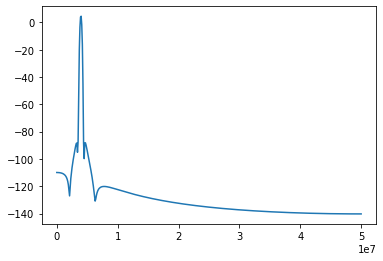

In [60]:
# Second (still naive) version of sfdr(x):
def sfdr(x,fs):
    Y = np.fft.rfft(x * signal.blackmanharris(len(x)))
    freqs = np.fft.rfftfreq(len(x), d=1.0/fs)
    mag = np.abs(Y)
    YdB = 20 * np.log10(mag)
    fig, ax = plt.subplots()
    ax.plot(freqs, YdB)
     
fundamental = 3959297  # Prime number
x = 10e-3*np.sin(2*np.pi*fundamental*t)
sfdr(x,fs)

Das sieht zwar schon besser aus, ist aber immer noch meilenweit von dem Dynamikbereich des Original-MATLAB-Diagramms entfernt, der sich ja über fast 300 dB erstreckt!

Man beachte zum Vergleich nochmal die Figure 2.28 b) auf Seite 53 in [dieser PDF-Datei des Buches!](https://www.analog.com/media/en/training-seminars/design-handbooks/Software-Defined-Radio-for-Engineers-2018/SDR4Engineers_CH02.pdf#page=14)

Was passt hier also nicht?
Kann es sein, dass die FFT-Funktionen von numpy weniger genau sind, Rechenfehler beinhalten oder aus irgendwelchen anderen Gründen weniger Dynamik zeigen als die MATLAB-Gegenstücke?
Das kann eigentlich nicht sein, denn die Spektren bei ganzzahliger Periodenzahl im Datensatz reichen ja bis -300 dB, wie man vorher sehen konnte!


### Kann MATLAB also zaubern? ###

Wenn nicht mal ein Blackman-Harris-Fenster ausreichend ist, das für seine hohe Unterdrückung bekannt ist, was hilft denn dann noch?

Eine Möglichkeit wäre, dass MATLAB den Abtastblock so verkürzt oder verlängert, dass eine exakte Zahl von Perioden reinpasst. Das wäre aber ein fieser Trick, weil MATLAB dann wirklich Datenwerte wegwerfen (oder dazudichten) würde!?

An dieser Stelle wollte ich schon aufgeben, aber dann habe ich die MATLAB-Help-Seite zu dieser Funktion gefunden (https://www.mathworks.com/help/signal/ref/sfdr.html), und dort steht in der Beschreibung der entscheidende Hinweis:

*Kaiser window with β = 38. The mean is subtracted from x before computing the power spectrum. The number of points used in the computation of the discrete Fourier transform (DFT) is the same as the length of the signal, x*

Und so hab ich es dann auch gemacht: 

### Dritter Versuch: Kaiser-Fenster mit β = 38 ###

Wie sieht denn so ein Kaiser-Fenster aus?
Lassen wir es uns gleich mal plotten:

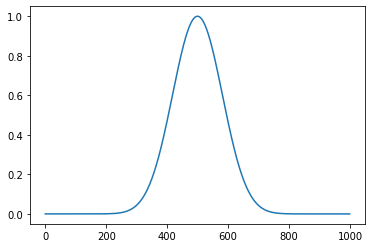

In [61]:
plt.plot(np.kaiser(1000,beta=38))

Mit diesem Kaiser-Fenster sieht die SFDR-Funktion dann so aus:

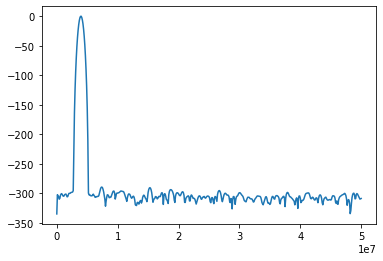

In [62]:
# Third version, using a Kaiser window
def sfdr(x,fs):
    xw = x * np.kaiser(len(x),beta=38)
    xw -= np.mean(xw)
    Y = np.fft.rfft(xw)
    freqs = np.fft.rfftfreq(len(xw), d=1.0/fs)
    mag = np.abs(Y)
    YdB = 20 * np.log10(mag)
    fig, ax = plt.subplots()
    ax.plot(freqs, YdB)
    
fundamental = 3959297  # Prime number
x = 10e-3*np.sin(2*np.pi*fundamental*t)
sfdr(x,fs)

Das sieht doch schon mal ganz gut aus!

## sfdr(x,fs): Python-Version ##

Die sfdr-Funktion von MATLAB multipliziert nicht nur den Datensatz mit dem Kaiser-Fenster und stellt dann die FFT dar.
Sie scheint auch sowohl die Fundamentale als auch den höchsten Störer zu suchen und deren Abstände zu bestimmen.
Außerdem fügt MATLAB noch ein paar nette Beschriftungen und Einfärbungen dazu.

Der folgende Code versucht, die Optik der MATLAB-sfdr-Funktion einigermaßen nachzuahmen:

In [63]:
# sfdr, with MATLAB-look
def sfdr(x,fs):
    xw = x * np.kaiser(len(x),beta=38) /len(x)
    xw -= np.mean(xw)
    Y = np.fft.rfft(xw)
    freqs = np.fft.rfftfreq(len(xw), d=1.0/fs)
    mag = np.abs(Y)
    YdB = 20 * np.log10(mag)
    peakind = signal.find_peaks_cwt(YdB, np.arange(3,9,3))
    pksf=freqs[peakind]
    pksY=YdB[peakind]
    isorted = np.argsort(pksY)
    sfdrval = pksY[isorted[-1]] - pksY[isorted[-2]]
    fig, ax = plt.subplots()
    pkfa = pksf[isorted[-1]]
    pkYa = pksY[isorted[-1]]
    pkfb = pksf[isorted[-2]]
    pkYb = pksY[isorted[-2]]
    plt.fill_between((0,fs/2),(pkYb,pkYb),(pkYa,pkYa), label = 'SFDR',
                     color = "lightblue")   
    ax.plot(pkfa, pkYa, marker="s", label = 'fundamental')
    ax.plot(pkfb, pkYb, marker="s", label = 'spurs')
    ax.plot(freqs, YdB)
    ax.set(xlabel = 'Frequency (Hz)', ylabel = 'Power (dB)',
           title = "SFDR %.2f dB" % sfdrval)
    ax.set_xlim(0, fs / 2)
    ax.set_ylim(-400, 10)   
    ax.legend(loc = "upper right")
    return sfdrval

Probieren wir das Ganze mal aus:

289.49027533107375

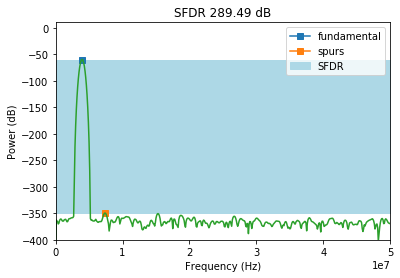

In [64]:
sfdr(x,fs)

Das ist mir jetzt ähnlich genug zu der Grafik im Buch; an dieser Stelle höre ich auf!